# Semantic analysis of sexism in French Rap using word embeddings

Natural Language Processing for the Social Sciences

Matteo Larrode, MSc Social Data Science

## Setup

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import wandb
from gensim.models import Word2Vec
import re

from utils.cleaning_helpers import *
from utils.visualisations_helpers import *
from utils.analysis_helpers import *
from utils.validation_helpers import *

set_visualization_style()

viridis = plt.get_cmap('viridis_r', 6) 

## Word Embeddings Training

In [ ]:
# Data is from 2024 ACL-SRW paper "A Computational Analysis and Exploration of Linguistic Borrowings in French Rap Lyrics" by Lucas Zurbuchen and Rob Voigt.
# Paper: https://aclanthology.org/2024.acl-srw.27.pdf
# Source: https://github.com/ljz112/CLResearch/tree/main/dataEntries

# Download the data from the GitHub repository & create csv files:
# python data_preprocessing.py
# Or to skip the download:
# python data_preprocessing.py --skip-download

In [17]:
# Load the data
songs_df = pd.read_pickle('data/processed_french_rap_songs.pkl')

songs_df.info()
print(type(songs_df['cleaned_lyrics'].iloc[0]))
print(songs_df['cleaned_lyrics'].iloc[0][:100])

<class 'pandas.core.frame.DataFrame'>
Index: 8208 entries, 0 to 11616
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              8208 non-null   int64 
 1   name            8208 non-null   object
 2   artists         8208 non-null   object
 3   releaseDate     8208 non-null   object
 4   popularity      8208 non-null   int64 
 5   lyrics          8208 non-null   object
 6   cleaned_lyrics  8208 non-null   object
 7   is_french       8208 non-null   bool  
 8   year            8208 non-null   int64 
 9   decade          8208 non-null   object
dtypes: bool(1), int64(3), object(6)
memory usage: 649.3+ KB
<class 'list'>
['moi', 'je', 'sais', 'ce', 'que', 'veux', 'tu', 'sais', 'est', 'quoi', 'mon', 'but', 'être', 'un', 'putain', 'de', 'bourgeois', 'gagner', 'du', 'blé', 'rien', 'glander', 'je', 'ne', 'veux', 'surtout', 'pas', 'retourner', 'où', 'étais', 'je', 'ne', 'veux', 'plus', 'cirer', 'les', 'pompes', 'u

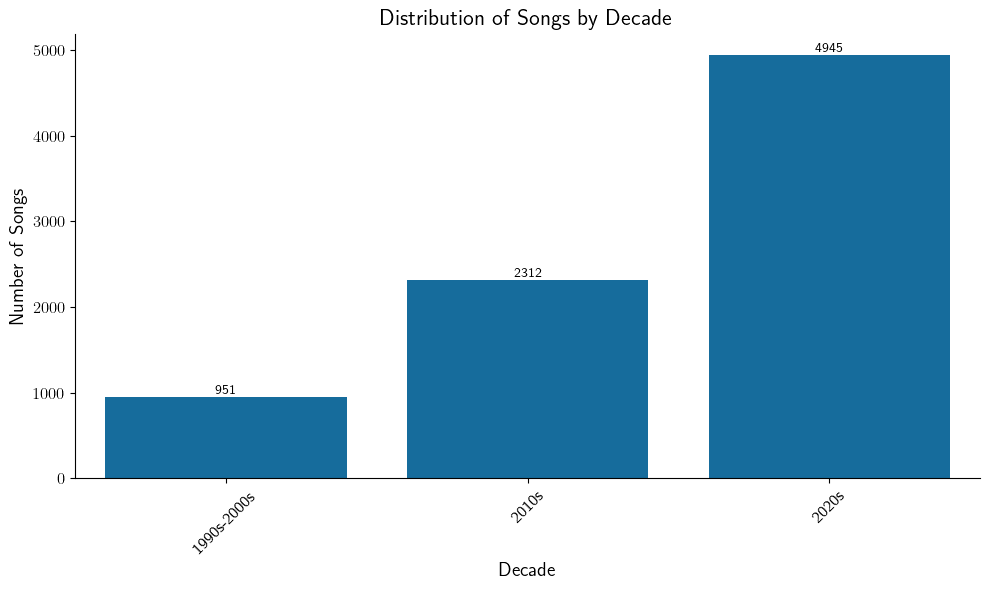

In [18]:
# Check number of songs per decade
plt.figure(figsize=(10, 6))
decade_counts = songs_df['decade'].value_counts().sort_index()
sns.barplot(x=decade_counts.index, y=decade_counts.values)
# Add number of songs on top of each bar
for i, count in enumerate(decade_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')
plt.title('Distribution of Songs by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Code inspired from Schmahl, K. G., Viering, T., Makrodimitris, S., Jahfari, A. N., Tax, D., & Loog, M. (2020). Is Wikipedia succeeding in reducing gender bias? Assessing changes in gender bias in Wikipedia using word embeddings. NLPCSS. https://doi.org/10.18653/V1/2020.NLPCSS-1.11

https://gitlab.com/kschmahl/wikipedia-gender-bias-over-time/

In [6]:
# Initialize W&B
wandb.init(project="french-rap-word-embeddings", name="simple-training")

# Group songs by decade
decades = songs_df['decade'].unique()
print(f"Decades in dataset: {decades}")

# Define parameters
vector_size = 100
window = 10
workers = 4
min_count = 5
iterations = 5
sg = 1  # Skip-gram model
seed = 42

# Train a model for each decade
for decade in decades:
    print(f"\nTraining model for {decade}...")
    
    # Get songs for this decade
    decade_songs = songs_df[songs_df['decade'] == decade]
    print(f"Number of songs: {len(decade_songs)}")
    
    # Use pre-tokenized lyrics if available
    if 'cleaned_lyrics' in decade_songs.columns:
        # Filter out any None or NaN values
        corpus = [tokens for tokens in decade_songs['cleaned_lyrics'].tolist() if tokens]
    else:
        print("Warning: No cleaned_lyrics found.")
        # Terminate the loop
        continue
    
    print(f"Corpus size: {len(corpus)} songs")
    
    # Create output directory
    output_dir = f'models/{decade}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Train the model
    model = Word2Vec(
        sentences=corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        epochs=iterations,
        sg=sg,
        seed=seed
    )
    
    # Log basic info to W&B
    wandb.log({
        "decade": decade,
        "num_songs": len(corpus),
        "vocab_size": len(model.wv.index_to_key)
    })
    
    # Save the model
    model_path = f'{output_dir}/rap_{decade}_model'
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Save vocabulary dictionary
    vocab_dict = {word: index for index, word in enumerate(model.wv.index_to_key)}
    with open(f'{model_path}-vocab.pkl', 'wb') as f:
        pickle.dump(vocab_dict, f)
    
    # Save vectors in numpy format
    np.save(f'{model_path}-vectors.npy', model.wv.vectors)

# Train model on the entire corpus
print("\nTraining model on all decades combined...")

# Combine all corpora
all_corpus = []
for decade in decades:
    decade_songs = songs_df[songs_df['decade'] == decade]
    if 'cleaned_lyrics' in decade_songs.columns:
        decade_corpus = [tokens for tokens in decade_songs['cleaned_lyrics'].tolist() if tokens]
        all_corpus.extend(decade_corpus)

print(f"Combined corpus size: {len(all_corpus)} songs")

# Create output directory for combined model
output_dir = 'models/all'
os.makedirs(output_dir, exist_ok=True)

# Train the combined model
all_model = Word2Vec(
    sentences=all_corpus,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4,
    epochs=iterations,
    sg=sg,
    seed=seed
)

# Log basic info to W&B
wandb.log({
    "decade": "all",
    "num_songs": len(all_corpus),
    "vocab_size": len(all_model.wv.index_to_key)
})

# Save the combined model
model_path = f'{output_dir}/rap_all_decades_model'
all_model.save(model_path)
print(f"Combined model saved to {model_path}")

# Save vocabulary dictionary
vocab_dict = {word: index for index, word in enumerate(all_model.wv.index_to_key)}
with open(f'{model_path}-vocab.pkl', 'wb') as f:
    pickle.dump(vocab_dict, f)

# Save vectors in numpy format
np.save(f'{model_path}-vectors.npy', all_model.wv.vectors)

# Finish the W&B run
wandb.finish()

print("Training complete!")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: matteo-larrode (matteo-larrode-university-of-oxford) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Decades in dataset: ['1990s-2000s' '2010s' '2020s']

Training model for 1990s-2000s...
Number of songs: 951
Corpus size: 951 songs
Model saved to models/1990s-2000s/rap_1990s-2000s_model

Training model for 2010s...
Number of songs: 2312
Corpus size: 2312 songs
Model saved to models/2010s/rap_2010s_model

Training model for 2020s...
Number of songs: 4945
Corpus size: 4945 songs
Model saved to models/2020s/rap_2020s_model

Training model on all decades combined...
Combined corpus size: 8208 songs
Combined model saved to models/all/rap_all_decades_model


num_songs,▁▂▅█
vocab_size,▁▂▅█
decade,all
num_songs,8208
vocab_size,26149


Training complete!


## Word Embedding Validation

In [4]:
models = load_models()

Loaded model: all
Loaded model: 2020s
Loaded model: 2010s
Loaded model: 1990s-2000s


### Intrinsic Evaluation 1 - Visualisation

First, let us evaluate the models using a visualisation after reducing dimensionality with t-SNE.

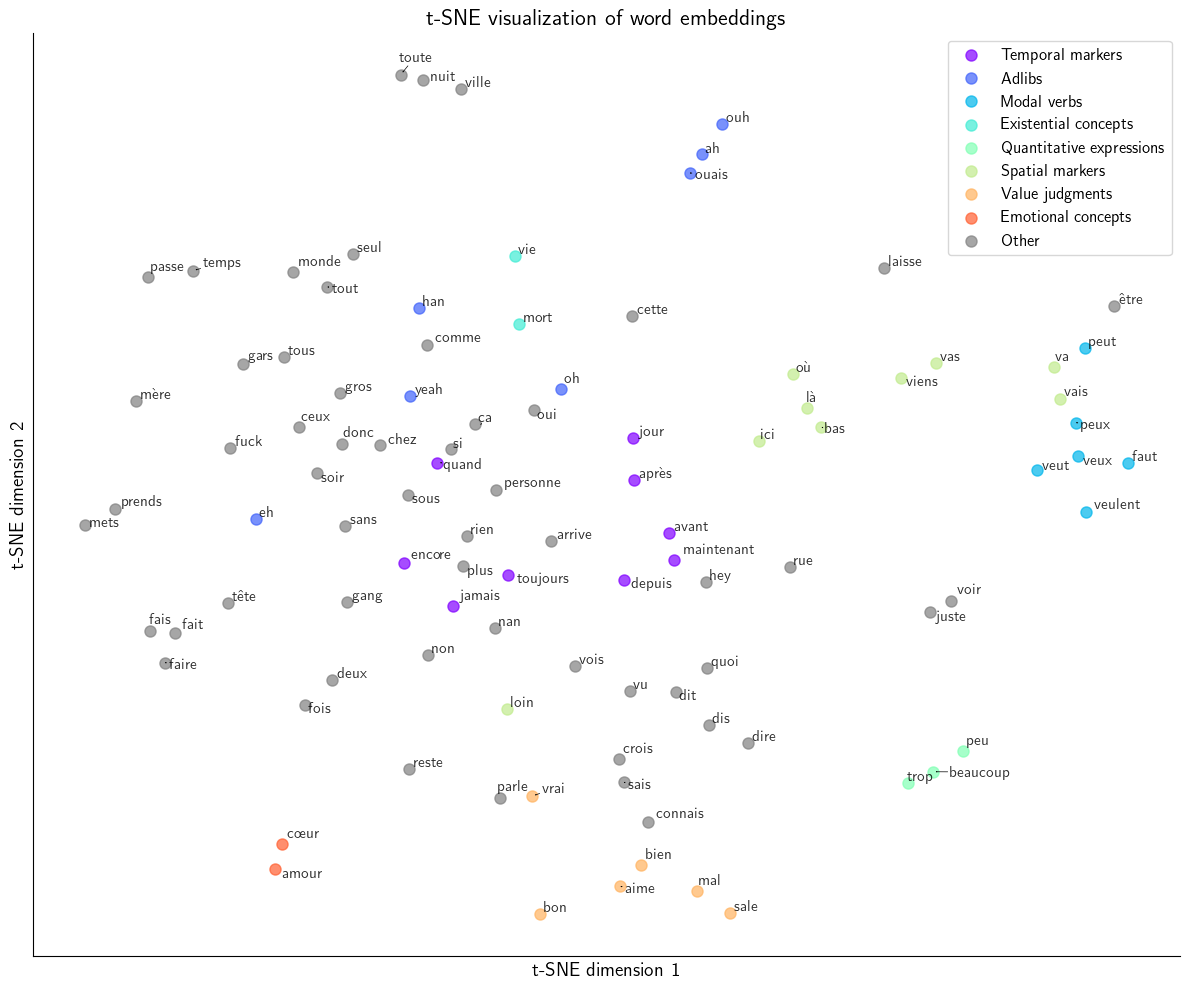

In [44]:
categories = {
    'modal_verbs': [
        'peut', 'veux', 'faut', 'veut', 'veulent', 'dois', 'peux', 
    ],
    'quantitative_expressions': [
        'peu', 'beaucoup', 'trop',
    ],
    'value_judgments': [
        'vrai', 'bon', 'mal', 'bien', 'aime', 'mauvais', 'sale'
    ],
    'emotional_concepts': [
        'cœur', 'amour', 'haine', 'peur', 'joie'
    ],
    'temporal_markers': [
        'avant', 'maintenant', 'depuis', 'après', 'toujours', 'jamais',
        'encore', 'déjà', 'jour', 'quand'
    ],
    'existential_concepts': [
        'vie', 'mort', 'existe', 'vivre', 'mourir'
    ],
    'adlibs': [
        'ouh', 'ah', 'oh', 'yo', 'yeah', 'ouais', 'eh', 'han'
    ],
    'spatial_markers': [
        'ici', 'là', 'loin', 'près', 'partout', 'nulle', 'où', 'bas', 'viens', 'vas', 'va', 'vais'
    ],
}

visualise_embeddings(
    models["all"],
    n_words=100,
    perplexity=5,
    categories=categories,
    save_path='french_rap_embeddings-100.png'
)

Several clusters can be identified from the t-SNE visualisation of word embeddings. In the upper left, 

### Intrinsic Evaluation 2- Semantic similarity

As a second way to validate the word embeddings created, I assess semantic similarity. The idea is to compare levels of similarity (using cosine distance) represented by my word embeddings to pairs of words generally considered as similar. I use Lakhzoum et al. (2021)'s normative database for 630 semantically similar French word pairs and associated levels of abstractness for 1260 isolated words [1].

----
[1] Lakhzoum, D., Izaute, M., & Ferrand, L. (2021). Semantic similarity and associated abstractness norms for 630 French word pairs. Behavior Research Methods, 53(3), 1166–1178. https://doi.org/10.3758/s13428-020-01488-z


In [4]:
# Word similarity dataset by Lakhzoum et al., 2021
# Source: https://osf.io/8m6af
similarities_dataset_url = "https://osf.io/download/8m6af/"

# Download and load the dataset
similarity_dict = parse_similarity_dataset(download_similarity_dataset(similarities_dataset_url))

# Add model similarities to the dictionary
similarities_test_results_dict = add_model_similarities(similarity_dict, models["all"])

Skipping word pair 'four-grille-pain' - could not parse properly
Skipping word pair 'rourge-gorge-moineau' - could not parse properly
Number of word pairs not in vocabulary: 178 / 626
Examples of missing pairs:
  (abeille, guêpe) - missing: guêpe
  (abolir, annuler) - missing: abolir
  (absurde, ridicule) - missing: absurde
  (acceptation, accord) - missing: acceptation
  (activisme, militantisme) - missing: activisme, militantisme
  ... and 173 more


In [ ]:
# Validate the embeddings
pearson_corr, pearson_p, spearman_corr, spearman_p, valid_pairs, total_pairs = validate_embeddings_on_similarities(similarities_test_results_dict)

Evaluation results:
Valid pairs: 448 / 626 (71.57%)
Pearson correlation: 0.0433 (p-value: 0.3600)
Spearman correlation: 0.0529 (p-value: 0.2638)


### Intrinsic validation 3 - Analogies

For the third part of the validation process, I partly follow Abdine et al. (2022)'s methodology of evaluating word embeddings [1]. Their first step is the **analogy task** [2]. In this task, we predict a word D by analyzing the semantic relationships between three input words A, B, and C. The prediction operates on the assumption that high-quality word embeddings preserve linear relationships between word pairs.

The process works as follows:

1. Given words A, B, and C, we access their vector representations (xA, xB, xC).
2. We compute a new vector using the formula: xB - xA + xC
3. We search the embedding dictionary for the word vector most similar to this result, which becomes our predicted word D.

For example, if we input "king," "man," and "woman," a good embedding system should predict "queen" because the relationship between "king" and "man" parallels the relationship between "queen" and "woman." Performance is measured by calculating the average accuracy across all test cases in the evaluation set. This approach effectively assesses how well word embeddings capture semantic relationships between concepts.

To evaluate my word embeddings, I utilised the French analogy dataset developed by Grave et al. (2018). This comprehensive dataset contains 31,688 analogy questions designed to test semantic and syntactic relationships [3]. I benchmarked my embeddings against three established French word vector models:

- French FastText (cc.fr.300) - also created by Grave et al. (2018)
- French Wacky word vectors
- Abdine et al. (2022)'s CBoW and Skip-Gram models trained on Large-Scale French Web Content

This comparative evaluation allows me to assess the relative performance of my embeddings against well-established baselines in capturing linguistic relationships within the French language context.

---------
[1]: Abdine, H., Xypolopoulos, C., Eddine, M. K., & Vazirgiannis, M. (2022). Evaluation Of Word Embeddings From Large-Scale French Web Content (No. arXiv:2105.01990). arXiv. https://doi.org/10.48550/arXiv.2105.01990

[2]: Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space (No. arXiv:1301.3781). arXiv. https://doi.org/10.48550/arXiv.1301.3781

[3]: Grave, E., Bojanowski, P., Gupta, P., Joulin, A., & Mikolov, T. (2018). Learning Word Vectors for 157 Languages. In N. Calzolari, K. Choukri, C. Cieri, T. Declerck, S. Goggi, K. Hasida, H. Isahara, B. Maegaard, J. Mariani, H. Mazo, A. Moreno, J. Odijk, S. Piperidis, & T. Tokunaga (Eds.), Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018). European Language Resources Association (ELRA). https://aclanthology.org/L18-1550/


In [ ]:
# Word analogy task from Grave et al., 2018
# Source: https://fasttext.cc/docs/en/crawl-vectors.html
analogies_dataset_url = "https://dl.fbaipublicfiles.com/fasttext/word-analogies/questions-words-fr.txt"

# Evaluate the full model and save correct analogies
analogies_test_results_df = validate_word_embeddings_on_analogies(
    models['all'], 
    save_correct=True
    )

Parsed 14 categories with a total of 31562 questions

Evaluating model: model
Evaluating category: antonyms-adjectives


100%|██████████| 648/648 [00:00<00:00, 1935.96it/s]


  Accuracy: 0.0055 (3/550)
Evaluating category: capital-common-countries


100%|██████████| 380/380 [00:00<00:00, 694784.45it/s]


  No questions could be answered (words not in vocabulary)
Evaluating category: capital-world


100%|██████████| 12210/12210 [00:00<00:00, 842296.21it/s]


  No questions could be answered (words not in vocabulary)
Evaluating category: city-in-state


100%|██████████| 7832/7832 [00:00<00:00, 842496.70it/s]


  No questions could be answered (words not in vocabulary)
Evaluating category: currency


100%|██████████| 800/800 [00:00<00:00, 588984.24it/s]


  No questions could be answered (words not in vocabulary)
Evaluating category: family


100%|██████████| 340/340 [00:00<00:00, 1791.20it/s]


  Accuracy: 0.1106 (23/208)
Evaluating category: gram1-adjective-to-adverb


100%|██████████| 926/926 [00:00<00:00, 8192.14it/s]


  Accuracy: 0.0000 (0/178)
Evaluating category: gram2-opposite


100%|██████████| 756/756 [00:00<00:00, 6575.74it/s]


  Accuracy: 0.0055 (1/182)
Evaluating category: gram3-present-participle


100%|██████████| 1258/1258 [00:00<00:00, 8153.79it/s]


  Accuracy: 0.0000 (0/238)
Evaluating category: gram4-past-participle


100%|██████████| 1122/1122 [00:00<00:00, 1717.93it/s]


  Accuracy: 0.0502 (53/1056)
Evaluating category: gram5-plural


100%|██████████| 1260/1260 [00:00<00:00, 2393.98it/s]


  Accuracy: 0.0069 (6/870)
Evaluating category: gram6-nationality-adjective


100%|██████████| 1600/1600 [00:00<00:00, 863025.51it/s]


  No questions could be answered (words not in vocabulary)
Evaluating category: gram7-past-tense


100%|██████████| 1560/1560 [00:00<00:00, 4386.64it/s]


  Accuracy: 0.0344 (19/552)
Evaluating category: gram8-plural-verbs


100%|██████████| 870/870 [00:00<00:00, 8519.14it/s]

  Accuracy: 0.0000 (0/56)

Overall accuracy: 0.0270 (105/3890)
Skipped questions: 27672
Saved correct analogies to results/correct_analogies_model.md
  Accuracy: 0.0270, Skipped: 27672


In [ ]:
# Get best and worst categories
# Get all category columns
category_columns = [col for col in analogies_test_results_df.columns 
                    if col not in ['Model', 'Overall_Accuracy', 'Skipped_Questions']]

# Sort categories by accuracy
if category_columns:
    # Get category accuracies from the single row, filtering out None values
    categories_acc = [(cat, analogies_test_results_df.iloc[0][cat]) for cat in category_columns if analogies_test_results_df.iloc[0][cat] is not None]
    # Sort by accuracy (descending)
    sorted_categories = sorted(categories_acc, key=lambda x: x[1], reverse=True)
    
    print("\nCategory Performance (best to worst):")
    for category, acc in sorted_categories:
        print(f"  {category}: {acc:.4f}")


Category Performance (best to worst):
  family: 0.1106
  gram4-past-participle: 0.0502
  gram7-past-tense: 0.0344
  gram5-plural: 0.0069
  gram2-opposite: 0.0055
  antonyms-adjectives: 0.0055
  gram1-adjective-to-adverb: 0.0000
  gram3-present-participle: 0.0000
  gram8-plural-verbs: 0.0000


In [ ]:
analogies_results_df_all_models = validate_word_embeddings_on_analogies(models, save_correct=True)

Parsed 14 categories with a total of 31562 questions

Evaluating model: all
Saved correct analogies to results/correct_analogies_all.md
  Accuracy: 0.0270, Skipped: 27672

Evaluating model: 2020s
Saved correct analogies to results/correct_analogies_2020s.md
  Accuracy: 0.0087, Skipped: 28462

Evaluating model: 2010s
Saved correct analogies to results/correct_analogies_2010s.md
  Accuracy: 0.0069, Skipped: 28805

Evaluating model: 1990s-2000s
Saved correct analogies to results/correct_analogies_1990s-2000s.md
  Accuracy: 0.0094, Skipped: 29530


**!! Limitation of the study: No extrinsic evaluation !!**

Extrinsic evaluation, which consists of testing the word embeddings on external tasks such as NER or parts-of-speech tagging, would allow to evaluate the actual usefulness of the embeddings.

## Gender Stereotypes Analysis